# Analisis de Sentimientos de Reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DrugReviews.csv')
column_names = df.columns
df = df.dropna()
print(column_names)

Index(['MedicineName', 'MedicineFor', 'ReviewDate', 'UserName', 'IntakeTime',
       'Reviews', 'ReviewLength', 'Rating', 'NumberOfLikes'],
      dtype='object')


In [ ]:
# Lista de strings para filtrar
strings_to_filter = ['Birth Control', 'Depression', 'Anxiety', 'Weight Loss', 'Pain', 'Acne', 'Insomnia', 'Bipolar Disorder', 'Diabetes, Type 2', 'High Blood Pressure']

# DataFrame vacío para almacenar los resultados
df_filtered_combined = pd.DataFrame()

# Loop for para filtrar, agrupar y reemplazar el valor de la columna 'MedicineFor'
for string in strings_to_filter:
    df_filtered = df[df['MedicineFor'].str.contains(string)]
    df_filtered['MedicineFor'] = string  # Reemplazar el valor de la columna 'MedicineFor'
    df_sampled = df_filtered.sample(n=2500, random_state=42) # Seleccionar aleatoriamente 2500 filas
    df_filtered_combined = pd.concat([df_filtered_combined, df_sampled])

df = df_filtered_combined
df


<ipython-input-39-866dedb8a4ac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['MedicineFor'] = string  # Reemplazar el valor de la columna 'MedicineFor'


,MedicineName,MedicineFor,ReviewDate,UserName,IntakeTime,Reviews,ReviewLength,Rating,NumberOfLikes
152937,Etonogestrel,Birth Control,23-Dec-16,Emilie,Not Specified,I've had expla for 3 months now at first I was...,532,10,6
283113,ParaGard,Birth Control,23-Sep-19,Carol...,Taken for 1 to 6 months,I've had my ParaGard for about 2 months now. I...,992,9,40
138989,Ethinyl estradiol / norethindrone,Birth Control,30-Sep-19,Nika,Taken for 6 months to 1 year,DO NOT TAKE THIS PILL IF YOU WANT TO LIVE! I'v...,1015,1,6
268859,Norethindrone,Birth Control,23-Jul-23,Jan,Taken for 1 to 6 months,I am giving this medicine a 5 out of 10 only b...,334,5,0
187443,Kyleena,Birth Control,26-Feb-20,Anonymous,Taken for 1 to 6 months,I got Kyleena inserted almost 2 months ago. In...,705,5,1
...,...,...,...,...,...,...,...,...,...
19234,Amlodipine / benazepril,High Blood Pressure,8-Oct-19,shar,Taken for 10 years or more,Have taken this combo med amlodipine with bena...,114,8,12
258515,Nebivolol,High Blood Pressure,3-Mar-19,Tired...,Not Specified,I monitor my BP daily. Was anywhere from 140's...,227,1,65
27686,Atenolol,High Blood Pressure,12-Jun-15,Zzzzz...,Not Specified,This is the worst medication I have ever taken...,267,1,36
174471,Hydrochlorothiazide,High Blood Pressure,22-Jul-11,Anonymous,Not Specified,I have used hydrochlorothiazide 12.5 mg for ab...,486,7,83


In [ ]:
df['Reviews'] = df['Reviews'].str.lower()
df['Reviews'] = df['Reviews'].str.strip()
df['Reviews'] = df['Reviews'].str.replace('[^\w\s]', '')
df['Reviews'] = df['Reviews'].str.replace('\d', '')
df['Reviews'] = df['Reviews'].str.replace('\\n', '')
df

,MedicineName,MedicineFor,ReviewDate,UserName,IntakeTime,Reviews,ReviewLength,Rating,NumberOfLikes
152937,Etonogestrel,Birth Control,23-Dec-16,Emilie,Not Specified,i've had expla for 3 months now at first i was...,532,10,6
283113,ParaGard,Birth Control,23-Sep-19,Carol...,Taken for 1 to 6 months,i've had my paragard for about 2 months now. i...,992,9,40
138989,Ethinyl estradiol / norethindrone,Birth Control,30-Sep-19,Nika,Taken for 6 months to 1 year,do not take this pill if you want to live! i'v...,1015,1,6
268859,Norethindrone,Birth Control,23-Jul-23,Jan,Taken for 1 to 6 months,i am giving this medicine a 5 out of 10 only b...,334,5,0
187443,Kyleena,Birth Control,26-Feb-20,Anonymous,Taken for 1 to 6 months,i got kyleena inserted almost 2 months ago. in...,705,5,1
...,...,...,...,...,...,...,...,...,...
19234,Amlodipine / benazepril,High Blood Pressure,8-Oct-19,shar,Taken for 10 years or more,have taken this combo med amlodipine with bena...,114,8,12
258515,Nebivolol,High Blood Pressure,3-Mar-19,Tired...,Not Specified,i monitor my bp daily. was anywhere from 140's...,227,1,65
27686,Atenolol,High Blood Pressure,12-Jun-15,Zzzzz...,Not Specified,this is the worst medication i have ever taken...,267,1,36
174471,Hydrochlorothiazide,High Blood Pressure,22-Jul-11,Anonymous,Not Specified,i have used hydrochlorothiazide 12.5 mg for ab...,486,7,83


In [ ]:
# Lista de strings para filtrar
strings_to_filter = ['Birth Control', 'Depression', 'Anxiety', 'Weight Loss', 'Pain', 'Acne', 'Insomnia', 'Bipolar Disorder', 'Diabetes, Type 2', 'High Blood Pressure']

# DataFrame vacío para almacenar los resultados
df_filtered_combined = pd.DataFrame()

# Loop for para filtrar, agrupar y reemplazar el valor de la columna 'MedicineFor'
for string in strings_to_filter:
    df_filtered = df[df['MedicineFor'].str.contains(string)]

    df_filtered['sentiment-TextBlob'] = df_filtered['Reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df_filtered_combined = pd.concat([df_filtered_combined, df_filtered])

df = df_filtered_combined
df

<ipython-input-51-60e0915b734b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment-TextBlob'] = df_filtered['Reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
<ipython-input-51-60e0915b734b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment-TextBlob'] = df_filtered['Reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
<ipython-input-51-60e0915b734b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,MedicineName,MedicineFor,ReviewDate,UserName,IntakeTime,Reviews,ReviewLength,Rating,NumberOfLikes,sentiment-BERT,sentiment-TextBlob-qualitative,sentiment-VADER,sentiment-VADER-qualitative,sentiment-TextBlob
152937,Etonogestrel,Birth Control,23-Dec-16,Emilie,Not Specified,i've had expla for 3 months now at first i was...,532,10,6,POSITIVE,NEGATIVE,-0.7839,NEGATIVE,-0.133750
283113,ParaGard,Birth Control,23-Sep-19,Carol...,Taken for 1 to 6 months,i've had my paragard for about 2 months now. i...,992,9,40,NEGATIVE,POSITIVE,0.8693,POSITIVE,0.111930
138989,Ethinyl estradiol / norethindrone,Birth Control,30-Sep-19,Nika,Taken for 6 months to 1 year,do not take this pill if you want to live! i'v...,1015,1,6,NEGATIVE,POSITIVE,-0.7595,NEGATIVE,0.021503
268859,Norethindrone,Birth Control,23-Jul-23,Jan,Taken for 1 to 6 months,i am giving this medicine a 5 out of 10 only b...,334,5,0,NEGATIVE,POSITIVE,-0.9251,NEGATIVE,0.091667
187443,Kyleena,Birth Control,26-Feb-20,Anonymous,Taken for 1 to 6 months,i got kyleena inserted almost 2 months ago. in...,705,5,1,NEGATIVE,NEGATIVE,-0.9410,NEGATIVE,-0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,Amlodipine / benazepril,High Blood Pressure,8-Oct-19,shar,Taken for 10 years or more,have taken this combo med amlodipine with bena...,114,8,12,POSITIVE,POSITIVE,0.4404,POSITIVE,0.200000
258515,Nebivolol,High Blood Pressure,3-Mar-19,Tired...,Not Specified,i monitor my bp daily. was anywhere from 140's...,227,1,65,POSITIVE,POSITIVE,-0.6908,NEGATIVE,0.000000
27686,Atenolol,High Blood Pressure,12-Jun-15,Zzzzz...,Not Specified,this is the worst medication i have ever taken...,267,1,36,NEGATIVE,NEGATIVE,-0.8858,NEGATIVE,-0.416667
174471,Hydrochlorothiazide,High Blood Pressure,22-Jul-11,Anonymous,Not Specified,i have used hydrochlorothiazide 12.5 mg for ab...,486,7,83,NEGATIVE,POSITIVE,-0.9127,NEGATIVE,0.109722


In [ ]:
sia = SentimentIntensityAnalyzer()
# Lista de strings para filtrar
strings_to_filter = ['Birth Control', 'Depression', 'Anxiety', 'Weight Loss', 'Pain', 'Acne', 'Insomnia', 'Bipolar Disorder', 'Diabetes, Type 2', 'High Blood Pressure']

# DataFrame vacío para almacenar los resultados
df_filtered_combined = pd.DataFrame()

# Loop for para filtrar, agrupar y reemplazar el valor de la columna 'MedicineFor'
for string in strings_to_filter:
    df_filtered = df[df['MedicineFor'].str.contains(string)]

    df_filtered['sentiment-VADER'] = df_filtered['Reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])
    df_filtered_combined = pd.concat([df_filtered_combined, df_filtered])

df = df_filtered_combined
df

<ipython-input-49-31aaec450adc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment-VADER'] = df_filtered['Reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])
<ipython-input-49-31aaec450adc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment-VADER'] = df_filtered['Reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])
<ipython-input-49-31aaec450adc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,MedicineName,MedicineFor,ReviewDate,UserName,IntakeTime,Reviews,ReviewLength,Rating,NumberOfLikes,sentiment-TextBlob,sentiment-BERT,sentiment-TextBlob-qualitative,sentiment-VADER-qualitative,sentiment-VADER
152937,Etonogestrel,Birth Control,23-Dec-16,Emilie,Not Specified,i've had expla for 3 months now at first i was...,532,10,6,-0.133750,POSITIVE,NEGATIVE,NEGATIVE,-0.7839
283113,ParaGard,Birth Control,23-Sep-19,Carol...,Taken for 1 to 6 months,i've had my paragard for about 2 months now. i...,992,9,40,0.111930,NEGATIVE,POSITIVE,POSITIVE,0.8693
138989,Ethinyl estradiol / norethindrone,Birth Control,30-Sep-19,Nika,Taken for 6 months to 1 year,do not take this pill if you want to live! i'v...,1015,1,6,0.021503,NEGATIVE,POSITIVE,NEGATIVE,-0.7595
268859,Norethindrone,Birth Control,23-Jul-23,Jan,Taken for 1 to 6 months,i am giving this medicine a 5 out of 10 only b...,334,5,0,0.091667,NEGATIVE,POSITIVE,NEGATIVE,-0.9251
187443,Kyleena,Birth Control,26-Feb-20,Anonymous,Taken for 1 to 6 months,i got kyleena inserted almost 2 months ago. in...,705,5,1,-0.125000,NEGATIVE,NEGATIVE,NEGATIVE,-0.9410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,Amlodipine / benazepril,High Blood Pressure,8-Oct-19,shar,Taken for 10 years or more,have taken this combo med amlodipine with bena...,114,8,12,0.200000,POSITIVE,POSITIVE,POSITIVE,0.4404
258515,Nebivolol,High Blood Pressure,3-Mar-19,Tired...,Not Specified,i monitor my bp daily. was anywhere from 140's...,227,1,65,0.000000,POSITIVE,POSITIVE,NEGATIVE,-0.6908
27686,Atenolol,High Blood Pressure,12-Jun-15,Zzzzz...,Not Specified,this is the worst medication i have ever taken...,267,1,36,-0.416667,NEGATIVE,NEGATIVE,NEGATIVE,-0.8858
174471,Hydrochlorothiazide,High Blood Pressure,22-Jul-11,Anonymous,Not Specified,i have used hydrochlorothiazide 12.5 mg for ab...,486,7,83,0.109722,NEGATIVE,POSITIVE,NEGATIVE,-0.9127


In [ ]:
sentiment_analyzer = pipeline("sentiment-analysis")
# Lista de strings para filtrar
strings_to_filter = ['Birth Control', 'Depression', 'Anxiety', 'Weight Loss', 'Pain', 'Acne', 'Insomnia', 'Bipolar Disorder', 'Diabetes, Type 2', 'High Blood Pressure']

# DataFrame vacío para almacenar los resultados
df_filtered_combined = pd.DataFrame()

# Loop for para filtrar, agrupar y reemplazar el valor de la columna 'MedicineFor'
for string in strings_to_filter:
    df_filtered = df[df['MedicineFor'].str.contains(string)]

    df_filtered['sentiment-BERT'] = df_filtered['Reviews'].apply(lambda x: sentiment_analyzer(x)[0]['label'])
    df_filtered_combined = pd.concat([df_filtered_combined, df_filtered])

df = df_filtered_combined
df

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
<ipython-input-43-ca340aee4e49>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment-BERT'] = df_filtered['Reviews'].apply(lambda x: sentiment_analyzer(x)[0]['label'])
<ipython-input-43-ca340aee4e49>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,MedicineName,MedicineFor,ReviewDate,UserName,IntakeTime,Reviews,ReviewLength,Rating,NumberOfLikes,sentiment-TextBlob,sentiment-VADER,sentiment-BERT
152937,Etonogestrel,Birth Control,23-Dec-16,Emilie,Not Specified,i've had expla for 3 months now at first i was...,532,10,6,-0.133750,-0.7839,POSITIVE
283113,ParaGard,Birth Control,23-Sep-19,Carol...,Taken for 1 to 6 months,i've had my paragard for about 2 months now. i...,992,9,40,0.111930,0.8693,NEGATIVE
138989,Ethinyl estradiol / norethindrone,Birth Control,30-Sep-19,Nika,Taken for 6 months to 1 year,do not take this pill if you want to live! i'v...,1015,1,6,0.021503,-0.7595,NEGATIVE
268859,Norethindrone,Birth Control,23-Jul-23,Jan,Taken for 1 to 6 months,i am giving this medicine a 5 out of 10 only b...,334,5,0,0.091667,-0.9251,NEGATIVE
187443,Kyleena,Birth Control,26-Feb-20,Anonymous,Taken for 1 to 6 months,i got kyleena inserted almost 2 months ago. in...,705,5,1,-0.125000,-0.9410,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...
19234,Amlodipine / benazepril,High Blood Pressure,8-Oct-19,shar,Taken for 10 years or more,have taken this combo med amlodipine with bena...,114,8,12,0.200000,0.4404,POSITIVE
258515,Nebivolol,High Blood Pressure,3-Mar-19,Tired...,Not Specified,i monitor my bp daily. was anywhere from 140's...,227,1,65,0.000000,-0.6908,POSITIVE
27686,Atenolol,High Blood Pressure,12-Jun-15,Zzzzz...,Not Specified,this is the worst medication i have ever taken...,267,1,36,-0.416667,-0.8858,NEGATIVE
174471,Hydrochlorothiazide,High Blood Pressure,22-Jul-11,Anonymous,Not Specified,i have used hydrochlorothiazide 12.5 mg for ab...,486,7,83,0.109722,-0.9127,NEGATIVE


In [ ]:
df.drop('sentiment-TextBlob-qualitative', axis=1, inplace=True)
# Crear la nueva columna 'Sentiment' basada en la condición
df['sentiment-TextBlob-qualitative'] = np.where(df['sentiment-TextBlob'] >= 0, 'POSITIVE', 'NEGATIVE')
#df['sentiment-VADER-qualitative'] = np.where(df['sentiment-VADER'] >= 0, 'POSITIVE', 'NEGATIVE')
df

,MedicineName,MedicineFor,ReviewDate,UserName,IntakeTime,Reviews,ReviewLength,Rating,NumberOfLikes,sentiment-BERT,sentiment-VADER,sentiment-VADER-qualitative,sentiment-TextBlob,sentiment-TextBlob-qualitative
152937,Etonogestrel,Birth Control,23-Dec-16,Emilie,Not Specified,i've had expla for 3 months now at first i was...,532,10,6,POSITIVE,-0.7839,NEGATIVE,-0.133750,NEGATIVE
283113,ParaGard,Birth Control,23-Sep-19,Carol...,Taken for 1 to 6 months,i've had my paragard for about 2 months now. i...,992,9,40,NEGATIVE,0.8693,POSITIVE,0.111930,POSITIVE
138989,Ethinyl estradiol / norethindrone,Birth Control,30-Sep-19,Nika,Taken for 6 months to 1 year,do not take this pill if you want to live! i'v...,1015,1,6,NEGATIVE,-0.7595,NEGATIVE,0.021503,POSITIVE
268859,Norethindrone,Birth Control,23-Jul-23,Jan,Taken for 1 to 6 months,i am giving this medicine a 5 out of 10 only b...,334,5,0,NEGATIVE,-0.9251,NEGATIVE,0.091667,POSITIVE
187443,Kyleena,Birth Control,26-Feb-20,Anonymous,Taken for 1 to 6 months,i got kyleena inserted almost 2 months ago. in...,705,5,1,NEGATIVE,-0.9410,NEGATIVE,-0.125000,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,Amlodipine / benazepril,High Blood Pressure,8-Oct-19,shar,Taken for 10 years or more,have taken this combo med amlodipine with bena...,114,8,12,POSITIVE,0.4404,POSITIVE,0.200000,POSITIVE
258515,Nebivolol,High Blood Pressure,3-Mar-19,Tired...,Not Specified,i monitor my bp daily. was anywhere from 140's...,227,1,65,POSITIVE,-0.6908,NEGATIVE,0.000000,POSITIVE
27686,Atenolol,High Blood Pressure,12-Jun-15,Zzzzz...,Not Specified,this is the worst medication i have ever taken...,267,1,36,NEGATIVE,-0.8858,NEGATIVE,-0.416667,NEGATIVE
174471,Hydrochlorothiazide,High Blood Pressure,22-Jul-11,Anonymous,Not Specified,i have used hydrochlorothiazide 12.5 mg for ab...,486,7,83,NEGATIVE,-0.9127,NEGATIVE,0.109722,POSITIVE


In [ ]:
df.to_excel('/content/drive/MyDrive/Drug review sentiment analysis.xlsx', index=False)

In [ ]:
X = df[['sentiment-VADER', 'sentiment-TextBlob']]
y = df['sentiment-BERT']
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.7664
              precision    recall  f1-score   support

    NEGATIVE       0.81      0.89      0.85      3609
    POSITIVE       0.61      0.46      0.52      1391

    accuracy                           0.77      5000
   macro avg       0.71      0.67      0.68      5000
weighted avg       0.75      0.77      0.76      5000



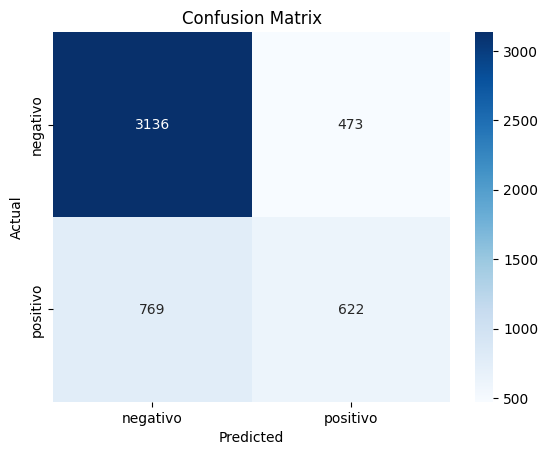

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()